In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import uproot, wandb, os, logging, json, random
import awkward as ak
# import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from matplotlib.ticker import FormatStrFormatter

# ML model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Config
from bdt_config import sample_dict, zbi, getVarDict
from bdt_config import Vars, Vars2, Vars3, Vars_drop, Vars_plot
from bdt_config import variables, ntuple_name, ntuple_name_BDT

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

# Check for gpu
# torch.cuda.is_available()

ModuleNotFoundError: No module named 'xgboost'

In [2]:
path = '/data/jlai/ntups/csv/BDT_input_basic.csv'
df = pd.read_csv(path)
df.describe()

,metsig,metsigres,met,met_noJVT,dmet,ph_pt,ph_eta,ph_phi,jet_central_eta,jet_central_pt1,...,softerm,jetterm,jetterm_sumet,dphi_met_central_jet,balance,dphi_jj,BDTScore,n_jet_central,weights,label
count,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,...,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06
mean,8.085141e+00,3.852044e+04,1.901262e+05,1.892991e+05,-8.271095e+02,9.048486e+05,8.146513e-01,-2.072798e-03,-9.753642e+00,8.822327e+05,...,9.443728e+03,8.356989e+05,1.146178e+06,-8.563278e+00,-7.972595e+00,-2.185869e+02,2.216015e-01,2.443367e+00,9.601491e-02,1.565822e-03
std,7.985699e+00,5.911545e+04,1.405338e+05,1.412619e+05,8.991675e+03,8.889817e+05,5.998204e-01,1.821790e+00,9.823051e+01,8.559987e+05,...,6.070485e+03,8.568927e+05,1.071807e+06,9.835174e+01,9.843597e+01,4.144786e+02,5.388693e-02,1.051786e+00,1.908170e+00,3.953949e-02
min,7.113951e-02,8.526343e+03,1.000000e+05,5.930758e+03,-1.712589e+05,5.000019e+04,1.202736e-06,-3.141592e+00,-9.990000e+02,-9.990000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,-9.990000e+02,-9.990000e+02,-9.990000e+02,1.000001e-01,0.000000e+00,-9.143369e+01,0.000000e+00
25%,2.618015e+00,1.708219e+04,1.162892e+05,1.155593e+05,0.000000e+00,1.767101e+05,3.292853e-01,-1.580835e+00,-6.314996e-01,1.797812e+05,...,4.888379e+03,1.707173e+05,2.673459e+05,1.135227e-01,9.812462e-01,1.014622e-01,1.856679e-01,2.000000e+00,3.252820e-05,0.000000e+00
50%,4.482013e+00,3.244079e+04,1.447310e+05,1.445859e+05,0.000000e+00,5.704866e+05,6.808950e-01,-8.222443e-03,-1.311714e-02,5.641862e+05,...,8.262512e+03,4.793933e+05,7.757431e+05,4.410775e-01,1.178055e+00,9.073769e-01,2.255408e-01,2.000000e+00,1.769263e-03,0.000000e+00
75%,1.201367e+01,5.355994e+04,2.090528e+05,2.092326e+05,0.000000e+00,1.522563e+06,1.171449e+00,1.575179e+00,5.929185e-01,1.425095e+06,...,1.275781e+04,1.370777e+06,1.820485e+06,2.621905e+00,1.660374e+00,2.254813e+00,2.598951e-01,3.000000e+00,1.991303e-02,0.000000e+00
max,1.899870e+02,8.154622e+07,6.400718e+07,6.400718e+07,1.246841e+05,5.011604e+06,2.518129e+00,3.141578e+00,2.499988e+00,5.262966e+06,...,1.022158e+05,5.019984e+06,1.016629e+07,3.141591e+00,2.090643e+02,3.141592e+00,4.375860e-01,4.000000e+00,5.740618e+02,1.000000e+00


In [3]:
Vars_drop = ['weights', 'label', 'process']

Number of event with negative weights : 85906


,metsig,met,met_noJVT,dmet,dphi_met_phterm,dphi_ph_centraljet1,dphi_phterm_jetterm,jetterm,dphi_met_central_jet,BDTScore,weights,label,metsigres,ph_pt,ph_eta,dphi_met_jetterm,failJVT_jet_pt1,n_jet_central,dphi_jj
count,2.374471e+06,2.374471e+06,2.374471e+06,2.374470e+06,2.374471e+06,2.351289e+06,2.357229e+06,2.374471e+06,2.351289e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.374471e+06,2.357051e+06,631246.000000,2.351752e+06,1.852064e+06
mean,8.085141e+00,1.901262e+05,1.892991e+05,-8.271094e+02,6.006525e-01,2.446962e+00,2.518814e+00,8.356989e+05,1.201708e+00,2.216015e-01,1.050441e-01,1.565822e-03,4.073824e-05,4.008329e-06,5.118788e+00,3.167647e+00,0.000037,5.078792e-01,6.276164e+00
std,7.985699e+00,1.405338e+05,1.412619e+05,8.991676e+03,7.738596e-01,9.045128e-01,9.077368e-01,8.568927e+05,1.213837e+00,5.388693e-02,1.907694e+00,3.953949e-02,2.747291e-05,4.732006e-06,5.480930e+02,3.461943e+01,0.000009,2.683609e-01,1.023126e+03
min,7.113951e-02,1.000000e+05,5.930758e+03,-1.712589e+05,0.000000e+00,5.841255e-06,0.000000e+00,0.000000e+00,0.000000e+00,1.000001e-01,0.000000e+00,0.000000e+00,1.226298e-08,1.995369e-07,3.971203e-01,3.183099e-01,0.000017,2.500000e-01,3.183099e-01
25%,2.618015e+00,1.162892e+05,1.155593e+05,0.000000e+00,9.246136e-02,2.038891e+00,2.154786e+00,1.707173e+05,1.180604e-01,1.856679e-01,8.014083e-05,0.000000e+00,1.867067e-05,6.567873e-07,8.536438e-01,3.335366e-01,0.000031,3.333333e-01,3.939393e-01
50%,4.482013e+00,1.447310e+05,1.445859e+05,0.000000e+00,2.531868e-01,2.930798e+00,3.061151e+00,4.793933e+05,4.587430e-01,2.255408e-01,2.678412e-03,0.000000e+00,3.082539e-05,1.752890e-06,1.468655e+00,3.925543e-01,0.000038,5.000000e-01,6.899687e-01
75%,1.201367e+01,2.090528e+05,2.092326e+05,0.000000e+00,7.491695e-01,3.097909e+00,3.125846e+00,1.370777e+06,2.630330e+00,2.598951e-01,2.438455e-02,0.000000e+00,5.854049e-05,5.658987e-06,3.036880e+00,1.822271e+00,0.000044,5.000000e-01,1.685788e+00
max,1.899870e+02,6.400718e+07,6.400718e+07,1.246841e+05,3.140301e+00,3.141592e+00,3.141593e+00,5.019984e+06,3.141591e+00,4.375860e-01,5.740618e+02,1.000000e+00,1.172836e-04,1.999992e-05,8.314374e+05,2.896309e+03,0.000050,1.000000e+00,1.048576e+06


Number of nan in each variable: 
metsig                        0
met                           0
met_noJVT                     0
dmet                          1
dphi_met_phterm               0
dphi_ph_centraljet1       23182
dphi_phterm_jetterm       17242
jetterm                       0
dphi_met_central_jet      23182
BDTScore                      0
weights                       0
label                         0
process                       0
metsigres                     0
ph_pt                         0
ph_eta                        0
dphi_met_jetterm          17420
failJVT_jet_pt1         1743225
n_jet_central             22719
dphi_jj                  522407
dtype: int64
random number:  88


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dlai211 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Best parameters found: {'gamma': 0.22716941331695786, 'learning_rate': 0.08791336602700374, 'max_depth': 7, 'n_estimators': 611, 'subsample': 0.9251936869842152}


/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:28:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


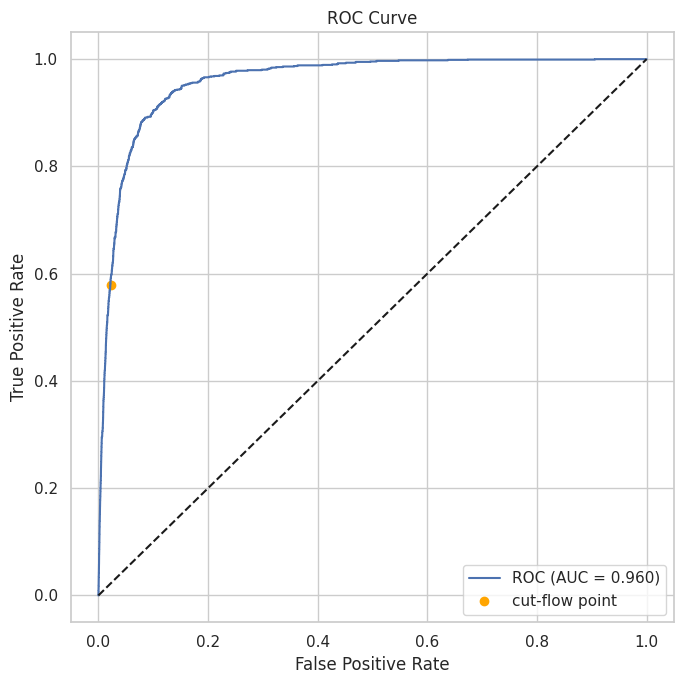

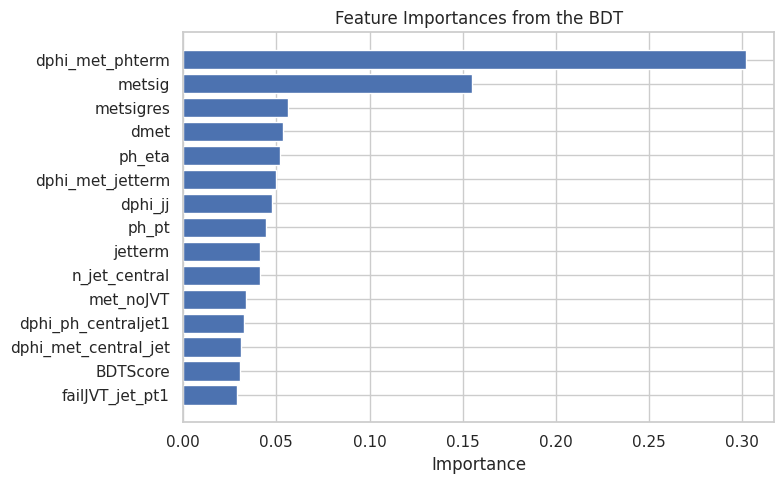

Best CV neg_log_loss,▁
Test Accuracy,▁
Test LogLoss,▁
Test ROC AUC,▁
Train Accuracy,▁
Train LogLoss,▁
Train ROC AUC,▁
iteration,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
test_auc,▁▅▅▅▆▆▆▇▇▇▇▇▇███████████████████████████
test_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_logloss,█▅▄▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:25:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:25:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the de

In [4]:
# === Data Perparation ===
df_Vars2 = df[Vars2].copy()
df_Vars3 = df[Vars3].copy()
df_Vars3.replace(-999, np.nan, inplace=True)
df_Vars3_inverted = 1 / df_Vars3.replace({0: np.nan})  # Avoid division by zero

df_ml_input = pd.concat([df_Vars2, df_Vars3_inverted], axis=1)
df_ml_input.replace(-999, np.nan, inplace=True)
print("Number of event with negative weights :", np.sum(df_ml_input.weights < 0))
df_ml_input["weights"] = df_ml_input["weights"].abs() # some of the weights are negative

display(df_ml_input.describe())

print("Number of nan in each variable: ")
print(df_ml_input.isna().sum())

# Define X (features) and y (labels)
X = df_ml_input.drop(Vars_drop, axis=1)
y = df_ml_input['label']
weights = df_ml_input['weights']

''' This will disrupt the bdtscore2
# === Standardize the Data (Optional) ===
scaler = StandardScaler()
X = scaler.fit_transform(X)
'''


random_num = random.randint(1, 100)
print("random number: ", random_num)

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=random_num, stratify=y)

wandb.init(project="Dark_ph BDT Random", reinit=True, resume=False)

param_distributions = {
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.001, 0.1),
    'n_estimators': randint(100, 700),
    'subsample': uniform(0.8, 0.2),
    'gamma': uniform(0.1, 1),               # higher = more pruning
}

xgb_clf = XGBClassifier(
    tree_method='hist',
    device='cuda',
    eval_metric=['logloss', 'error', 'auc'],
    early_stopping_rounds=10,
    missing=np.nan,  # Let XGBoost handle any remaining NaNs
    random_state=random_num
)

random_search = RandomizedSearchCV(
    xgb_clf, param_distributions, n_iter=20, scoring='roc_auc', refit=True,
    cv=5, n_jobs=-1, random_state=random_num
)

random_search.fit(X_train, y_train,
          sample_weight=sw_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          sample_weight_eval_set=[sw_train, sw_test],
          verbose=False)

best_model = random_search.best_estimator_
wandb.config.update(random_search.best_params_)
wandb.log({"Best CV neg_log_loss": random_search.best_score_})
print("Best parameters found:", random_search.best_params_)

# Generate BDT score predictions for all data
df_ml_input["bdtscore2"] = best_model.predict_proba(df_ml_input.drop(Vars_drop, axis=1))[:, 1]

results = best_model.evals_result()
train_loss = results['validation_0']['logloss']
test_loss = results['validation_1']['logloss']
train_error = results['validation_0']['error']
test_error = results['validation_1']['error']
train_auc = results['validation_0']['auc']
test_auc = results['validation_1']['auc']

for i, (train_l, test_l, train_e, test_e, train_a, test_a) in enumerate(zip(train_loss, test_loss, train_error, test_error, train_auc, test_auc)):
    wandb.log({
        "train_logloss": train_l,
        "test_logloss": test_l,
        "train_error": train_e,
        "test_error": test_e,
        "train_auc": train_a,
        "test_auc": test_a,
        "iteration": i
    })

y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

metrics = {
    "Train LogLoss": log_loss(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test LogLoss": log_loss(y_test, y_test_pred_proba, sample_weight=sw_test),
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_test_pred),
    "Train ROC AUC": roc_auc_score(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test ROC AUC": roc_auc_score(y_test, y_test_pred_proba, sample_weight=sw_test)
}

wandb.log(metrics)

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba, sample_weight=sw_test)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label="ROC (AUC = {:.3f})".format(metrics["Test ROC AUC"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("roc_randomsearch.png")
wandb.log({"ROC Curve": wandb.Image("roc_randomsearch.png")})
plt.show()

importances = best_model.feature_importances_
indices = np.argsort(importances)
selected_columns = df_ml_input.drop(Vars_drop+['bdtscore2'], axis=1).columns

plt.figure(figsize=(8, 5))
plt.barh(range(len(selected_columns)), importances[indices], align='center')
plt.yticks(range(len(selected_columns)), [selected_columns[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances from the BDT')
plt.tight_layout()
plt.savefig("feature_importance.png")
wandb.log({"Feature Importance": wandb.Image("feature_importance.png")})
plt.show()

wandb.finish()

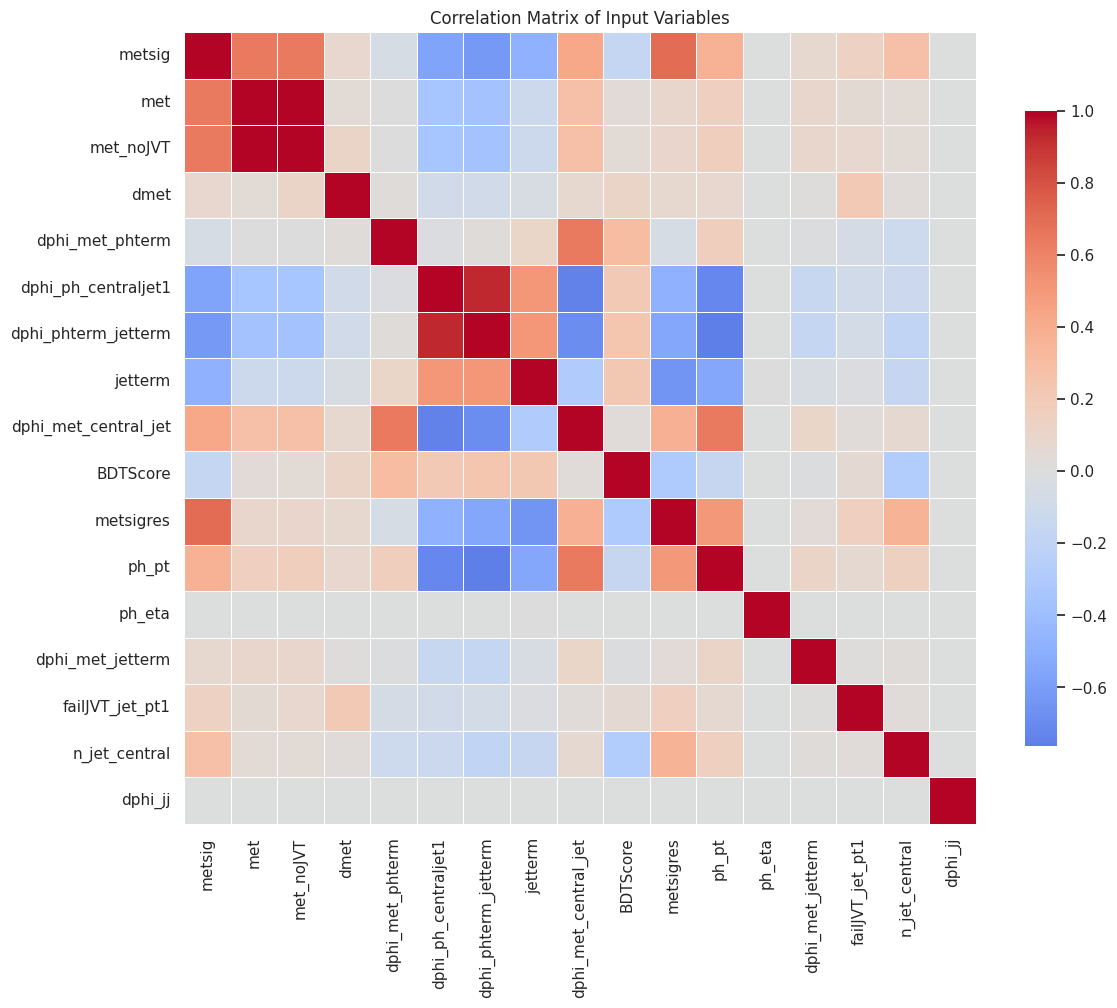

In [5]:
import seaborn as sns

# Reconstruct the full feature matrix (drop label, weights, and bdtscore)
corr_features = df_ml_input.drop(Vars_drop + ['bdtscore2'], axis=1)

# Calculate correlation matrix
corr_matrix = corr_features.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Input Variables")
plt.tight_layout()
plt.savefig("correlation_matrix.png")
plt.show()


Saved plot to significance_bdtscore2_lowercut.png


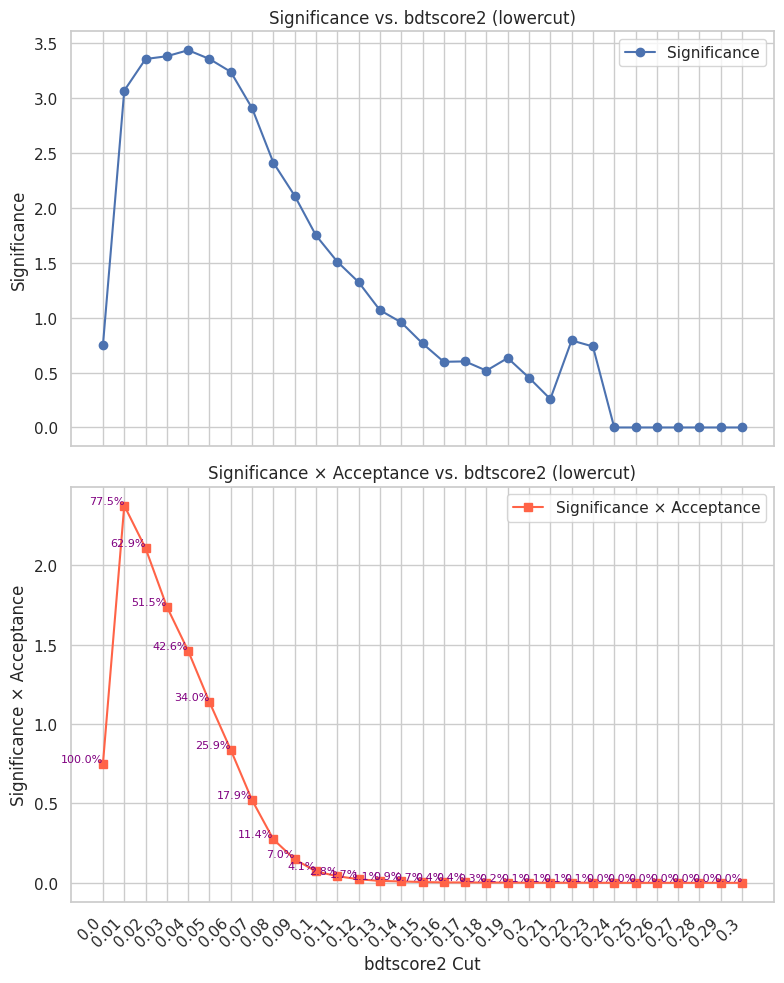

/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [00:42:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [00:42:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the de

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def binomial_significance(s, b):
    return s / np.sqrt(b) if b > 0 else 0

def scan_significance(df, cut_var="bdtscore2", cut_type="lowercut", cuts=np.arange(0, 0.71, 0.01)):
    sig_values = []
    sig_acc_values = []
    acc_values = []

    df_sig = df[df["label"] == 1]
    df_bkg = df[df["label"] == 0]
    total_sig_weight = df_sig["weights"].sum()

    for cut in cuts:
        if cut_type == "lowercut":
            sig_cut = df_sig[df_sig[cut_var] >= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] >= cut]
        elif cut_type == "uppercut":
            sig_cut = df_sig[df_sig[cut_var] <= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] <= cut]
        else:
            raise ValueError("Invalid cut type")

        s = sig_cut["weights"].sum()
        b = bkg_cut["weights"].sum()
        acceptance = s / total_sig_weight if total_sig_weight > 0 else 0
        significance = binomial_significance(s, b)

        sig_values.append(significance)
        sig_acc_values.append(significance * acceptance)
        acc_values.append(acceptance * 100)  # percentage

    return cuts, sig_values, sig_acc_values, acc_values

def plot_significance(cuts, sig, sig_acc, acc, cut_var, cut_type, save_path):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    ax1.plot(cuts, sig, marker='o', label='Significance')
    ax1.set_ylabel('Significance')
    ax1.set_title(f'Significance vs. {cut_var} ({cut_type})')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(cuts, sig_acc, marker='s', color='tomato', label='Significance × Acceptance')
    for i, a in enumerate(acc):
        ax2.text(cuts[i], sig_acc[i], f"{a:.1f}%", fontsize=8, color='purple', ha='right', va='bottom')
    
    ax2.set_xlabel(f'{cut_var} Cut')
    ax2.set_ylabel('Significance × Acceptance')
    ax2.set_title(f'Significance × Acceptance vs. {cut_var} ({cut_type})')
    ax2.grid(True)
    ax2.legend()
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xticks(cuts)
    ax2.set_xticklabels(cuts, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Saved plot to {save_path}")
    plt.show()
    # plt.close()

cut_var = "bdtscore2"
cut_type = "lowercut"
cut_values = np.arange(0, 0.31, 0.01)

cuts, sig, sig_acc, acc = scan_significance(df_ml_input, cut_var, cut_type, cut_values)

plot_significance(
    cuts, sig, sig_acc, acc,
    cut_var=cut_var,
    cut_type=cut_type,
    save_path=f"significance_{cut_var}_{cut_type}.png"
)

In [32]:
bdtscore2_cut = 0.08
signal_bdtscore2_cut = df_ml_input[(df_ml_input.label==1) & (df_ml_input.bdtscore2 >= bdtscore2_cut)]['weights'].sum()
bkg_bdtscore2_cut = df_ml_input[(df_ml_input.label==0) & (df_ml_input.bdtscore2 >= bdtscore2_cut)]['weights'].sum()
signal_bdtscore2_cut / np.sqrt(bkg_bdtscore2_cut)

4.220629863189821

In [36]:
bdt_sig = df_ml_input[(df_ml_input.label==1) & (df_ml_input.bdtscore2 >= 0.05)]['weights']
bdt_bkg = df_ml_input[(df_ml_input.label==0) & (df_ml_input.bdtscore2 >= 0.05)]['weights']

(0.0, 0.4)

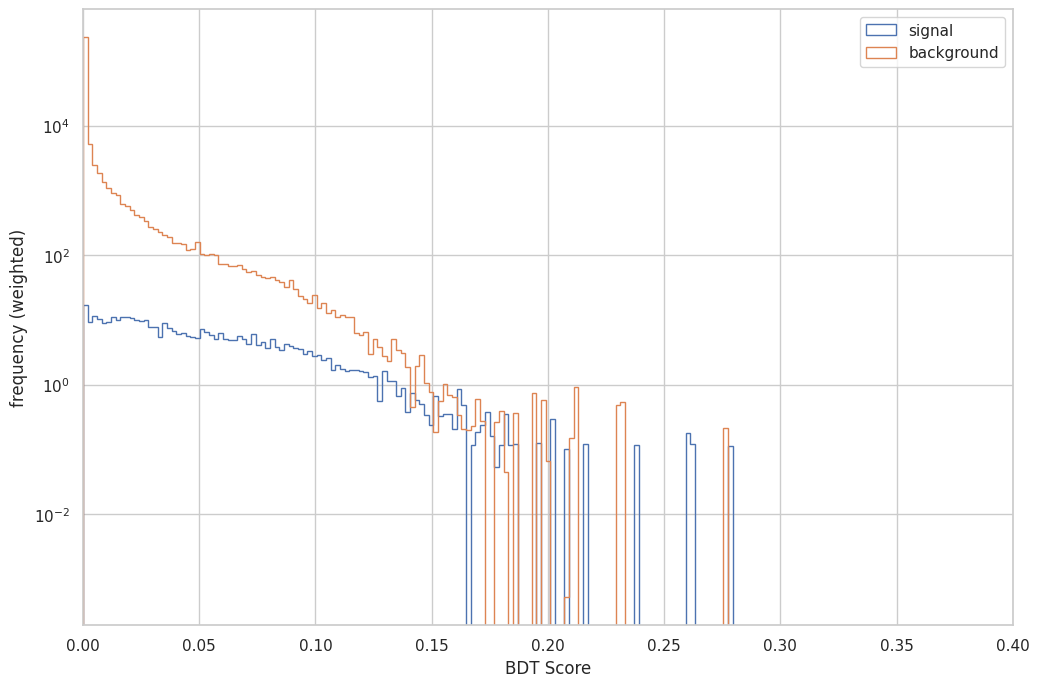

In [7]:
bins = np.linspace(0, 0.4, 200)
plt.hist(df_ml_input[df_ml_input.label==1]['bdtscore2'], histtype='step', linewidth=1, bins=bins, weights=df_ml_input[df_ml_input.label==1]['weights'], label='signal')
plt.hist(df_ml_input[df_ml_input.label==0]['bdtscore2'], histtype='step', linewidth=1, bins=bins, weights=df_ml_input[df_ml_input.label==0]['weights'], label='background')
plt.yscale('log')
plt.legend()
plt.ylabel('frequency (weighted)')
plt.xlabel('BDT Score')
plt.xlim(0, 0.4)